In [1]:
### Imports
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
import matplotlib.pyplot as plt 
import pydicom 
import pydicom.data 
from pathlib import Path
import gc
import warnings
warnings.filterwarnings("ignore")
import sys
import time
####
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
####
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim
import torchvision.transforms as transforms
import torchvision
##
from fastprogress import master_bar, progress_bar
from PIL import Image
gc.collect()

0

In [2]:
full_train_df = pd.read_csv(Path('image_labels_train.csv'))

full_train_df.head()

,image_id,rad_ID,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Situs inversus,Pneumonia,Pleuro-pneumonia,Diagphramatic hernia,Tuberculosis,Congenital emphysema,CPAM,Hyaline membrane disease,Mediastinal tumor,Lung tumor
0,6cb53aff85c71b98ad13d67a131708c6,R3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40414c05687cdb156823c156967b13f0,R3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0e4a464dfbf8abc6333c82f1b77b6455,R3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f4d3fab0b71381e6b237dc36301e85a0,R3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,b58c9b1c89978a0b1f8533b7a2ca1088,R3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
cols = ['No finding', 'Bronchitis', 'Brocho-pneumonia',
       'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia',
       'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM',
       'Hyaline membrane disease', 'Mediastinal tumor','Lung tumor']


data_df = []

for i in cols:
    oneVal = sum(np.where(full_train_df[i] == 1,1,0))
    zeroVal = sum(np.where(full_train_df[i] == 0,1,0))
    data_df.append([i,oneVal,zeroVal])
    
data_df = pd.DataFrame(data_df)
data_df.columns = ['Label','oneVal','zeroVal']
data_df


,Label,oneVal,zeroVal
0,No finding,5143,2585
1,Bronchitis,842,6886
2,Brocho-pneumonia,545,7183
3,Other disease,412,7316
4,Bronchiolitis,497,7231
5,Situs inversus,11,7717
6,Pneumonia,392,7336
7,Pleuro-pneumonia,6,7722
8,Diagphramatic hernia,3,7725
9,Tuberculosis,14,7714


In [4]:
LABELS = full_train_df.columns[2:]
LABELS

Index(['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease',
       'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia',
       'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM',
       'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor'],
      dtype='object')

In [5]:
class CustomNet(nn.Module):
    def __init__(self, num_classes=15, is_trained=False):
        super().__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3), # inp (3, 512, 512)
            nn.Conv2d(8, 16, 3),
            nn.MaxPool2d(2),
            nn.ReLU() # op (16, 256, 256)
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(16, 32, 5), # inp (16, 256, 256)
            nn.Conv2d(32, 32, 3),
            nn.MaxPool2d(4),
            nn.ReLU() # op (32, 64, 64)
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # inp (32, 64, 64)
            nn.Conv2d(64, 64, 5),
            nn.MaxPool2d(2),
            nn.ReLU() # op (64, 32, 32)
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(64, 128, 5), # inp (64, 32, 32)
            nn.Conv2d(128, 128, 3),
            nn.MaxPool2d(2),
            nn.ReLU() # op (128, 16, 16)
        )
        #self.Lin1 = nn.Linear(15488, 15)
        self.Lin1 = nn.Sequential(nn.Linear(512, 15), nn.Sigmoid())        
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.Lin1(x)
        
        return x

In [6]:
####################################################################################
###   ResNet18
####################################################################################
#
class ResNet18(nn.Module):
    def __init__(self, num_classes=15, is_trained=False):

        super().__init__()
        self.net = torchvision.models.resnet18(pretrained=is_trained)
        # Get the input dimension of last layer
        #kernel_count = self.net.classifier.in_features

        ## Freeze first 8 layers
        ct = 0
        for child in self.net.children():
            ct += 1
            if ct < 9:
                for param in child.parameters():
                    param.requires_grad = False
                
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 15),nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)
    

In [7]:
class ChestXrayDataset(Dataset):
    
    def __init__(self, folder_dir, dataframe, transform):
        """
        Init Dataset
        
        Parameters
        ----------
        folder_dir: str
            folder contains all images
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] # List of image paths
        self.image_labels = [] # List of image labels
        
        # Define list of image transformations
        self.transform = transform
        
        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            image_path = folder_dir+str(row.image_id)+'.dicom'
            self.image_paths.append(image_path)
            labels = []
            for col in row[2:]:
                if col == 1:
                    labels.append(1)
                else:
                    labels.append(0)
            self.image_labels.append(labels)
    
    def __len__(self):
        return len(self.image_paths)
    
#     def __getitem__(self, index):
#         """
#         Read image at index and convert to torch Tensor
#         """
        
#         # Read image
#         image_path = self.image_paths[index]
# #         image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels
#         images_data = pydicom.dcmread(image_path)
#         pil_image_data = Image.fromarray(images_data.pixel_array, mode="L")
#         image_data = pil_image_data.convert("RGB")
#         # TODO: Image augmentation code would be placed here
        
#         # Resize and convert image to torch tensor 
#         image_data = self.image_transformation(pil_image_data)
        
#         return image_data, torch.FloatTensor(self.image_labels[index])

    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """
        # Read image
        image_path = self.image_paths[index]
        
        dataset = pydicom.dcmread(image_path, force=True)
        pil_image_data = Image.fromarray(dataset.pixel_array, mode="L")
        
        pil_image_data = pil_image_data.convert('RGB')
        # TODO: Image augmentation code would be placed here

        # Resize and convert image to torch tensor 
        image_data = self.transform(pil_image_data)
        return image_data, torch.FloatTensor(self.image_labels[index])

In [8]:
IMAGE_SIZE = 224                              # Image size (224x224)
BATCH_SIZE = 96                              
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 2 ##100                              # Maximum number of training epochs

In [9]:
train_data, val_data = train_test_split(full_train_df, test_size=0.20, random_state=2021)
del full_train_df
gc.collect()
print(train_data.image_id.size)
print(val_data.image_id.size)

6182
1546


In [10]:
path = r'C:/Users/HP/Desktop/Untitled Folder/train/'

In [11]:
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [12]:
my_data_path = path
train_dataset = ChestXrayDataset(my_data_path, train_data, train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Num of training batches', len(train_dataloader))
# for data, label in train_dataloader:
#     print(data.size())
#     print(label.size())
#     break

Num of training batches 65


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache()
device

'cpu'

In [14]:
val_dataset = ChestXrayDataset(my_data_path, val_data, train_transform)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Num of training batches', len(val_dataloader))
# for data, label in val_dataloader:
#     print(data.size())
#     print(label.size())
#     break

Num of training batches 17


In [15]:
del train_data
del val_data
del train_dataset
del val_dataset
gc.collect()

15

In [16]:
def multi_label_auroc(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    auroc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        try:
            auroc.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
        except ValueError:
            pass
    return auroc

def multi_label_accuracy(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    acc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        acc.append(accuracy_score(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0)))
    return acc

def multi_label_f1(y_gt, y_pred):
    """ Calculate f1 for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    f1_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        f1_out.append(f1_score(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0)))
    return f1_out


def multi_label_precision_recall(y_gt, y_pred):
    """ Calculate precision for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction
        
    Returns
    -------
    list
        precision of each class
    """
    precision_out = []
    recall_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        p = precision_recall_fscore_support(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0),average='binary')
        precision_out.append(p[0])
        recall_out.append(p[1])
    return precision_out,recall_out

In [17]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
        # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        #pred = torch.LongTensor(pred)
        loss = loss_criteria(pred, labels)
        #print("loss is ",loss)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        #mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

In [18]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """
 
    # Switch model to evaluation mode
    model.eval()


    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    
    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)
            
            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            #mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    val_loss_mean = val_loss/len(val_loader)
    auroc_mean = np.nanmean(np.array(multi_label_auroc(out_gt, out_pred)))
    acc_mean = np.nanmean(np.array(multi_label_accuracy(out_gt, out_pred)))
    f1_mean = np.nanmean(np.array(multi_label_f1(out_gt, out_pred)))
    
    print('accuracy_mean = {}, f1_mean = {} ',acc_mean,f1_mean)
    
    return val_loss_mean,auroc_mean,acc_mean,f1_mean


In [19]:
def get_opt(modeltxt,model):
    
    if modeltxt == "ResNet18":
        return optim.Adam(model.parameters())
    
    if modeltxt == "CustomNet":
        return optim.Adam(model.parameters())

In [20]:
def trainModel(modelname,loss_criteria,modeltxt):
    model = modelname(num_classes=len(LABELS),is_trained=True).to(device)

    optimizer = get_opt(modeltxt,model)
    # Learning rate will be reduced automatically during training
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR,
                                                        patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)
    best_score = 0
    best_score_acc = 0
    best_score_f1 = 0
    modeltxt = r"\resnet18"
    
    model_path = out+modeltxt+".pth"
    out_path = out+modeltxt+"_running.csv"
    training_losses = []
    validation_losses = []
    validation_score = []
    validation_acc = []
    validation_f1 = []


    # Config progress bar
    mb = master_bar(range(MAX_EPOCHS))
    mb.names = ['Train loss', 'Val loss', 'AUROC', 'Accuracy', 'f1 score']
    x = []

    nonimproved_epoch = 0
    start_time = time.time()
    cnt = 1
    # Training each epoch
    for epoch in mb:
        #break
        mb.main_bar.comment = f'Best AUROC score: {best_score}'
        x.append(epoch)

        # Training
        train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
        mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
        training_losses.append(train_loss)

        # Evaluating
        mb.write('evualuate')
        val_loss, new_score, new_score_acc, new_score_f1 = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)

        validation_losses.append(val_loss)
        validation_score.append(new_score)
        validation_acc.append(new_score_acc)
        validation_f1.append(new_score_f1)

        gc.collect()
        # Update learning rate
        lr_scheduler.step(new_score)

        # Update training chart
        mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score] , [x, validation_acc] ,
                         [x, validation_f1]],
                        [0,epoch+1+round(epoch*0.3)], [0,1])

        diff = np.round(time.time() - start_time)
        pd.DataFrame([[epoch,modeltxt,best_score,new_score,diff]]).to_csv(out_path,index=False,mode='a',header=False)
        # Save model
        t2 = 4
        if best_score < new_score:
            #mb.write(f"Improve AUROC from {best_score} to {new_score}")    
            best_score = new_score
            best_score_acc = new_score_acc
            best_score_f1 = new_score_f1
            nonimproved_epoch = 0
            best_model = model
            torch.save({"model": model.state_dict(), 
                        "optimizer": optimizer.state_dict(), 
                        "best_score": best_score, 
                        "epoch": epoch, 
                        "lr_scheduler": lr_scheduler.state_dict()}, model_path)
        else: 
            nonimproved_epoch += 1
        if nonimproved_epoch > 5:
            break
            print("Early stopping")
        if time.time() - start_time > 3600*t2:
            break
            print("Out of time")

    
    return best_score,best_score_acc,best_score_f1,best_model

In [21]:
model_list = [CustomNet,ResNet18]
mName_list = ['CustomNet','ResNet18']

In [22]:
import torchvision.models as models
# Define the model
model = models.resnet18(pretrained=True)

# Define the path where you want to save the model
save_path = r'C:\Users\HP\Desktop\Untitled Folder\models'+r'\ResNet18.pth'  # Replace 'path_to_your_folder' with the actual folder path

# Save the model state dictionary to the specified path
torch.save(model.state_dict(), save_path)

out = r'C:\Users\HP\Desktop\Untitled Folder\models'

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

Processing Model ResNet18 with focal loss function


accuracy_mean = {}, f1_mean = {}  0.9314359637774902 0.0


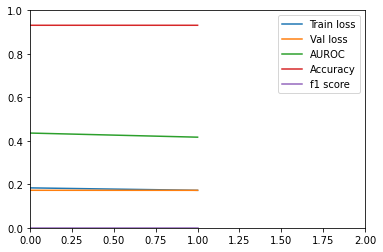

accuracy_mean = {}, f1_mean = {}  0.9313928417421302 0.0


In [24]:
eval_df_train = []
# for m in model_list:
#     mName = m().__class__.__name__
#     print("Processing Model ",mName)
#     globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"],globals()[f"best_model_{mName}"] = trainModel(modelname=m,loss_criteria=nn.BCELoss(),modeltxt=mName)
#     eval_df_train.append([mName,globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"]])
    
model_List2 = [ResNet18]
for m in model_List2: 
    mName = m().__class__.__name__
    print("Processing Model ResNet18 with focal loss function")
    globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"],globals()[f"best_model_{mName}"] = trainModel(modelname=m,loss_criteria=FocalLoss(alpha=1, gamma=2, reduction='mean'),modeltxt=mName)
    eval_df_train.append([mName,globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"]])

In [ ]:
eval_df_train=pd.DataFrame(eval_df_train)
eval_df_train.columns = ['Model Name','AUROC', 'Accuracy', 'f1 Score']
eval_df_train.to_csv(out+"eval_df_train.csv",index=False)
eval_df_train

In [54]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters_all(model):
    return sum(p.numel() for p in model.parameters())

param_list = []
i = 0
for model in model_list:
    modelName = model().__class__.__name__
    num_params_all = count_parameters_all(model())
    num_params = count_parameters(model())
    param_list.append([modelName,num_params_all,num_params])

param_list=pd.DataFrame(param_list)
param_list.columns = ['Model Name','Total Parameters','Trainable Parameters']
param_list

,Model Name,Total Parameters,Trainable Parameters
0,ResNet18,11244111,67599


In [55]:
del train_dataloader
del val_dataloader
gc.collect()

6499

In [57]:
path = r'C:/Users/HP/Desktop/Untitled Folder/'
full_test_df = pd.read_csv(path+'image_labels_test.csv')

In [58]:
full_test_df.size

23749

In [59]:
BATCH_SIZE = 1
my_data_path = r'C:/Users/HP/Desktop/Untitled Folder/test/'
test_dataset = ChestXrayDataset(my_data_path, full_test_df, train_transform)
#test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
for data, label in test_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([1, 3, 224, 224])
torch.Size([1, 15])


In [60]:
del test_dataset
del full_test_df
gc.collect()

23

In [64]:
 def getTestPreds(best_model,test_dataloader,modeltxt):
    y_pred_t = torch.FloatTensor().to(device)      # Tensor stores prediction values
    y_test_t = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    y_pred_list = []
    y_test_list = []

    test_auroc = []
    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []

    with torch.no_grad():

        best_model.eval()
        for X_batch, labels in test_dataloader:
            X_batch = X_batch.to(device)
            labels = labels.to(device)

            ps = best_model(X_batch)

            y_test_t = torch.cat((y_test_t,  labels), 0)
            y_pred_t = torch.cat((y_pred_t, ps), 0)
            
            test_acc.append(np.mean(multi_label_accuracy(y_test_t, y_pred_t)))
            test_f1.append(np.mean(multi_label_f1(y_test_t, y_pred_t)))
            test_auroc.append(np.mean(multi_label_auroc(y_test_t, y_pred_t)))
            
            p,r = multi_label_precision_recall(y_test_t, y_pred_t)
            test_precision.append(np.mean(p))
            test_recall.append(np.mean(r))
        
        test_auroc = np.nanmean(test_auroc)
        test_acc = np.nanmean(test_acc)
        test_f1 = np.nanmean(test_f1)
        test_precision = np.nanmean(test_precision)
        test_recall = np.nanmean(test_recall)
        
        print("AUROC : ",test_auroc)
        print("Accuracy : ",test_acc)
        print("f1 score : ",test_f1)
        print("precision score : ",test_precision)
        print("recall score : ",test_recall)
        
        eval_matrix = [modeltxt,test_auroc,test_acc,test_f1,test_precision,test_recall]
        
        return y_test_t,y_pred_t,eval_matrix

############## Plot
def plot_conf(y_test,y_pred,modeltxt):
    f, axes = plt.subplots(2, 7, figsize=(25, 8))
    f.suptitle('Confustion Matrix For Model '+ modeltxt, fontsize=20, fontweight='bold')
    plt.rcParams.update({'font.size': 14,'font.weight': 'bold'})
    y_test = y_test.cpu()
    y_pred = np.where(y_pred.cpu()>0.5,1,0)
    axes = axes.ravel()
    for i in range(14):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                       y_pred[:, i]))
        disp.plot(ax=axes[i], values_format='.10g')
        disp.ax_.set_title(f'{LABELS[i]}')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()
    
################# Get Values

def get_conf(y_test,y_pred,modeltxt):
    conf_vals = []
    y_test = y_test.cpu()
    y_pred = np.where(y_pred.cpu()>0.5,1,0)
    for i in range(15):
        c = confusion_matrix(y_test[:, i],y_pred[:, i])
        #p = c[0][0]
        #q = c[0][1]
        #r = c[1][0]
       # s = c[1][1]
        try:
            p = c[0][0]
        except IndexError:
            p = 0

        try:
            q = c[0][1]
        except IndexError:
            q = 0
            
        try:
            r = c[1][0]
        except IndexError:
            r = 0
            
        try:
            s = c[1][1]
        except IndexError:
            s = 0
        
        conf_vals.append([modeltxt,LABELS[i],p,q,r,s])

    return conf_vals

In [69]:
globals()[f"best_model_{mName}"]

KeyError: 'best_model_resnet18'

In [71]:
eval_matrix_all = []
for mName in mName_list:
    print("Predicting for Model ",mName)
    globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],eval_matrix = getTestPreds(globals()[f"best_model_{mName}"],test_dataloader,mName)
    eval_matrix_all.append(eval_matrix)
    print("----------------------------------------------")

Predicting for Model  ResNet18
AUROC :  0.5507192569300474
Accuracy :  0.9141492574030546
f1 score :  0.02416237294205977
precision score :  0.020644886776518462
recall score :  0.03231484050088187
----------------------------------------------


In [73]:
label_list_all = []
for mName in mName_list:
    #print("Model ",mName)
    for i in range(15):
        acc = accuracy_score(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0))
        p = precision_recall_fscore_support(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0),average='binary')
        #print(LABELS[i]," ==> ","Acc : ",acc," Precision : ",p[0]," Recall : ",p[1])  
        
        #print(LABELS[i],p)
        label_list_all.append([mName,LABELS[i],acc,p[0],p[1]])
    

df_label_list_all = pd.DataFrame(label_list_all)
df_label_list_all.columns = ["Model Name","Label","Accuracy","Precision","Recall"]
df_label_list_all.to_csv(out+"df_label_list_all.csv",index=False)
df_label_list_all

,Model Name,Label,Accuracy,Precision,Recall
0,ResNet18,No finding,0.624195,0.694106,0.753032
1,ResNet18,Bronchitis,0.875447,0.000000,0.000000
2,ResNet18,Brocho-pneumonia,0.939871,0.000000,0.000000
3,ResNet18,Other disease,0.944882,0.000000,0.000000
4,ResNet18,Bronchiolitis,0.935576,0.000000,0.000000
5,ResNet18,Situs inversus,0.998568,0.000000,0.000000
6,ResNet18,Pneumonia,0.936292,0.000000,0.000000
7,ResNet18,Pleuro-pneumonia,1.000000,0.000000,0.000000
8,ResNet18,Diagphramatic hernia,1.000000,0.000000,0.000000
9,ResNet18,Tuberculosis,0.999284,0.000000,0.000000
